In [1]:
import numpy as np #importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import glob
import scipy
from pylab import *
from scipy import *

In [2]:
start = "arochime-invpfbB0329+54_32768chan3ntbin" #setting strings to make calling files easier/shorter, since most of them share the same name
fold = "foldspec_2018-08-16T10:"
icount = "icount_2018-08-16T10:"
end = ".000+30.000000000000004sec"

In [3]:
def half_min_test(num): #function to determine whether time is in half a minute or whole minute
    if num == 30:
        return '30'
    else:
        return '00'

In [4]:
pt = np.loadtxt('pulse_times.txt').T #loading file of times of pulses
pt = pt.astype(int)

In [5]:
def load(filenames,i): #function for loading in files in a for loop
    data_fold = np.load(start+fold+str(filenames[0,i])+":"+half_min_test(filenames[1,i])+end+".npy")    #loading data from folded pulses
    data_count = np.load(start+icount+str(filenames[0,i])+":"+half_min_test(filenames[1,i])+end+".npy") #loading data from icount file
    return data_fold, data_count ## shape = (3,32768,512,4), (3,32768,512)

In [6]:
def normalize(data_fold,data_count):                               #function for normalizing raw data
    norm_data = data_fold/data_count.reshape(data_count.shape+(1,))
    return norm_data                                               #shape = (3,32768,512,4)

In [7]:
def meandiv_2(norm_data,i):                                                  #function for dividing normalized data by mean
                                                                           #of normalized data for a given time along the
                                                                           #frequency axis to 'clean' it up
    mean_div = norm_data[i,:,:]/norm_data[i,:,:].mean(1, keepdims=True)
    return mean_div                                                        #shape = (32768,512)

In [8]:
def remove_baseline(mean_div):          #function for removing baseline from a given file
    f_summed = np.sum(mean_div,axis=0)  #summing cleaned, normalized data along the frequency axis
                                        #shape = (512)
    base = np.mean(f_summed)            #determining baseline as mean of the weights of the phases along the newly\
                                        #created frequency-summed-over array
    sigma = np.std(f_summed)            #determining standard deviation of the weights of the phases along the newly\
                                        #created frequency-summed-over array
    data_new_baseline = f_summed - base #determining data without baseline by subtracting baseline from newly created\
                                        #frequency-summed-over array
    return data_new_baseline, sigma, base

In [9]:
def find_pulse(data_new_baseline,sigma):
    lower = int(len(data_new_baseline))     #initializing lower bound as maximum possible value
    upper = 0                               #initializing upper bound as minimum possible value
    for i in range(len(data_new_baseline)): #looping over all phases in baseline-corrected phase data
        if (data_new_baseline[i] > sigma):  #conditional to check the positions in the array of the phase values which
                                            #have a weight greater than a standard deviation
            if lower>i:                     #determining lowest and higest values of the phase weights higher than one
                                            #standard deviation to determine start and stop of phase
                lower = i
            elif upper<i:
                upper = i
    return lower, upper

In [10]:
n = len(sorted(glob.glob('test_outputs/*.npy')))/2 #determining the number of files in the folder
n = int(n) #converting number of files into an integer so it can be itterated over

bounds = np.zeros((int(n*3),3)) #n number of files * 3 time bins per file length

All_Folded_Data = np.zeros((n,3,32768,512,4)) #defining arrays to store all loaded data
All_Count_Data = np.zeros((n,3,32768,512))

In [11]:
%%time
#master = np.zeros((len(data_fold[0,:,0,0]),n*3))
k = 0
for j in range(0,n,1):
    folded = np.load(start+fold+str(pt[0,j])+":"+half_min_test(pt[1,j])+end+".npy")    #loading data from folded pulses
    count = np.load(start+icount+str(pt[0,j])+":"+half_min_test(pt[1,j])+end+".npy") #loading data from icount file
    All_Folded_Data[j] = folded #loading data into array containing all loaded data such that each file can be called upon later without need to load it into the notebook again
    All_Count_Data[j] = count
    normalized = normalize(folded,count) #normalizing data
    summed = normalized[:,:,:,0]+normalized[:,:,:,3] #adding XX and YY polarization axis
    for i in range(len(summed[:,0,0])): #iterating over time bins
        
        mean_data = meandiv_2(summed,i) #dividing my mean
        no_baseline_data,stdev,base = remove_baseline(mean_data) #removing baseline data and determining baseline and standard deviation
        lb,ub = find_pulse(no_baseline_data,stdev) #finding lower and upper bound for each pulse
        
        bounds[k] = (lb,ub,base) #storing the upper and lower bound values in an array contaning bounds for pulse for each time axis
        k = k+1

CPU times: user 3min 6s, sys: 5min 57s, total: 9min 3s
Wall time: 9min 43s


In [12]:
lower_bound = int(np.floor(np.mean(bounds[:,0]))) #determining average of lower and upper bounds to determine constant bounds
upper_bound = int(np.ceil(np.mean(bounds[:,1])))
print(upper_bound)
print(lower_bound)

458
434


In [13]:
def pulse_profile_2(data): #defining function to calculate weighted average of data clean data
    upper = upper_bound
    lower = lower_bound
    
    phase_only = np.mean(data,axis=0,keepdims=True) #averaging data along time axis, keeping dimensions
    phase_only = np.sum(phase_only[0,:,:],axis=0) #averaging data along the frequency axis, result is a 1D array with weighted phase values
    
    profile = np.zeros_like(phase_only) #creating an array of 0's length equal to the number of phase bins
    profile[lower:upper] = phase_only[lower:upper] #assinging pulse reigon of phase to on pulse profile array
    
    off_gate = np.zeros_like(phase_only) #creating an array of 0's length equal to the number of phase bins
    off_gate[100:200] = 1 #assigning 1 to off pulse profile array over relativelly large phase interval not containing pulse
    
    weighted_avg_on = np.sum(data*profile,axis=2)/np.sum(profile) #calculating weighted average of on pulse data
    
    weighted_avg_off = np.sum(data*off_gate,axis=2)/np.sum(off_gate) #calculating weighted average of off pulse data
    
    cleaned_data = weighted_avg_on/weighted_avg_off - 1 #cleaning up data

    return cleaned_data

In [14]:
def mask_bands_2(data):
    for i in range(len(data[0,:])):
        if (i >= 10500 and i <= 11700) or (i >= 13500 and i <= 14000) or (i >= 15000 and i <= 15500) or (i >= 26500 and i <= 29250): #conditional for noisy frequency bands
            data[:,i] = 0           #weighing down the RFI frequencies
    return data

In [15]:
%%time
k=0
h=0
for j in range(0,n,1):
    folded_data = All_Folded_Data[j] #getting raw folded data from master array
    count_data = All_Count_Data[j] #getting raw count data from master array
    normalized = normalize(folded_data,count_data) #normalizing raw data
    summed_data = (normalized[:,:,:,0] + normalized[:,:,:,3]) #summing XX and YY polarization axis
    
    clean = pulse_profile_2(summed_data) #calculating weighted average of data and cleaning data

    masked_pulse_data = mask_bands_2(clean) #masking noisy frequency channels

    if (j == 0):
        master_stack = masked_pulse_data #assigning data to master array for concatenation along time axis
    else:
        master_stack = np.concatenate((master_stack,masked_pulse_data)) #concatenating data to master array along time axis
            

CPU times: user 2min 35s, sys: 2min 27s, total: 5min 2s
Wall time: 5min 4s


In [16]:
print(master_stack.shape) #result is a 1D array of time,frequency with shape (number of time bins per file * number of data files, number of frequency bins)

(129, 32768)


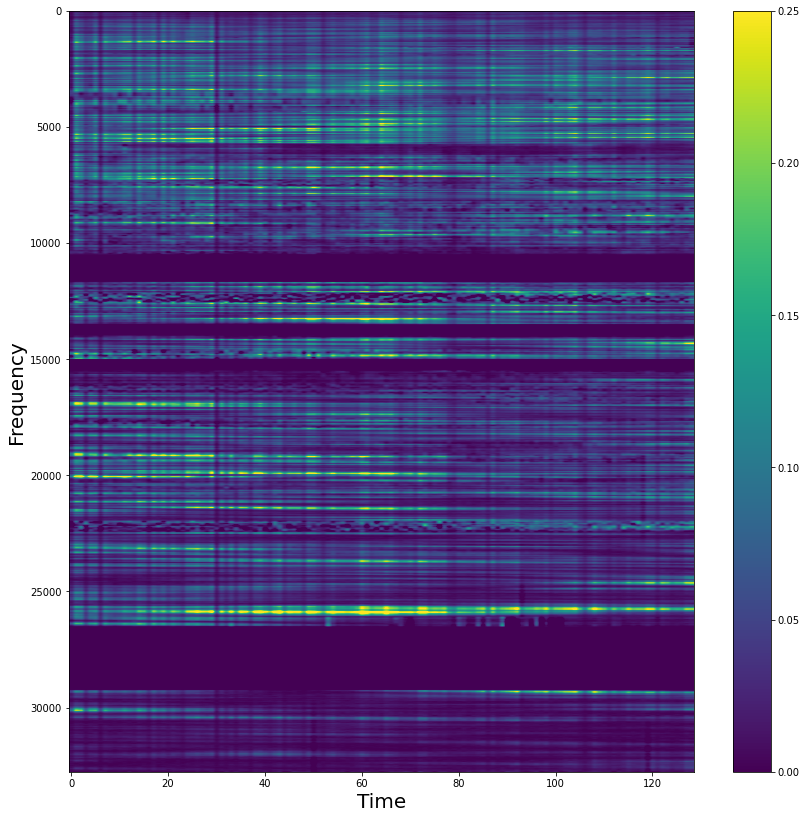

CPU times: user 11.6 s, sys: 415 ms, total: 12 s
Wall time: 14.3 s


In [17]:
%%time
plt.figure(figsize=(14,14))
plt.imshow(master_stack.T,aspect='auto',vmin=0,vmax=0.25) #transposing concatenated data to ensure that x and y axis are correctly orientated on the plot
plt.xlabel('Time', size=20)
plt.ylabel('Frequency', size=20)
plt.colorbar()
plt.savefig('../Dynamic/Dynamic_Spectra_test_20.png')
plt.show()

In [18]:
print(this_object_is_not_defined)

NameError: name 'this_object_is_not_defined' is not defined

In [21]:
%%time
a = [1,2,3]
print(a+b)

In [ ]:
# %%time
# SN_Weights = np.linalg.svd(master_stack)
# SN_Weights.shape

In [18]:
no_cleaning = np.fft.fft2(master_stack)
nocleaning_shift = np.fft.fftshift(no_cleaning)

In [19]:
norm_no_cleaning = np.sqrt(nocleaning_shift.real**2 + nocleaning_shift.imag**2)

CPU times: user 214 ms, sys: 4 ms, total: 218 ms
Wall time: 215 ms


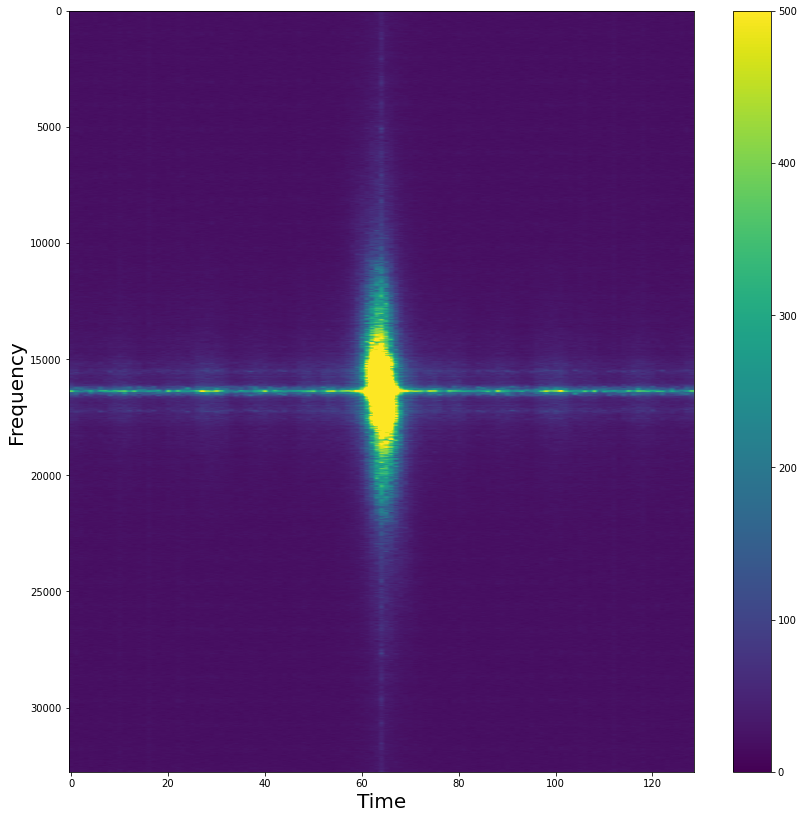

In [20]:
%%time
plt.figure(figsize=(14,14))
plt.imshow(norm_no_cleaning.T,aspect='auto',interpolation=None,vmin=0,vmax=500) #transposing concatenated data to ensure that x and y axis are correctly orientated on the plot
plt.xlabel('Time', size=20)
plt.ylabel('Frequency', size=20)
plt.colorbar()
# plt.savefig('../Dynamic/Fourier_Transform_Dynamic_Spectra_Test_2.png')

In [21]:
Rough_SN_Weights = master_stack.mean(axis=1,keepdims=True)
new_master_stack = master_stack/Rough_SN_Weights

In [22]:
print(Rough_SN_Weights.shape)

(129, 1)


In [23]:
def chop_off_bad(data):
    for i in range(len(data[0,:])):
        if (i >= 10500 and i <= 11700) or (i >= 13500 and i <= 14000) or (i >= 15000 and i <= 15500) or (i >= 26500 and i <= 29250): #conditional for noisy frequency bands
            data[:,i] = nan           #weighing down the RFI frequencies
    return data

In [24]:
n_data = chop_off_bad(new_master_stack)

In [25]:
def weighted_nanmean(data,SN,raw_data): #defining function to calculate weighted average of data clean data
#     nan_mean_data = np.nanmean(data,axis=0,keepdims=True) #averaging data along time axis, keeping dimensions
#     nan_mean_data = np.nansum(nan_mean_data,axis=0) #averaging data along the frequency axis, result is a 1D array with weighted phase values
    
#     bin_step = int(256)
#     new_f_bins = int(128)
    
    
    bin_step = int(len(data[0,:])/len(raw_data[0,0,:,0])) #returns 64 bins = 32768/512
    new_f_bins = len(raw_data[0,0,:,0]) #512 bins
    
    binned_data = np.zeros((len(data[:,0]),new_f_bins)) #creating an array of 0's of length 129,64
    
    for i in range(new_f_bins): #for 512 itterations over i
        binned_data[:,i] = np.nansum(data[:,i:i+bin_step]*SN,axis=1)/np.nansum(SN)
    
#         weighted_avg_SN = np.nansum(data*SN,axis=0)/np.nansum(SN) #calculating weighted average by rough SN ratio of frequency time data
#         print(weighted_avg_SN.shape)

    nan_mean = np.nanmean(data)

    for j in range(len(binned_data[0,:])):
        for k in range(len(binned_data[:,0])):
            if (binned_data[k,j] == nan):
                binned_data[k,j] = nan_mean
    
    return binned_data

In [26]:
def weighted_mean_2(data,SN,raw_data): #defining function to calculate weighted average of data clean data
#     nan_mean_data = np.nanmean(data,axis=0,keepdims=True) #averaging data along time axis, keeping dimensions
#     nan_mean_data = np.nansum(nan_mean_data,axis=0) #averaging data along the frequency axis, result is a 1D array with weighted phase values
    
    bin_step = int(32768/128) #returns 256 bins = 32768/128
    new_f_bins = int(128) #512 bins
    
    binned_data = np.zeros((len(data[:,0]),new_f_bins)) #creating an array of 0's of length 129,64
    
    for i in range(new_f_bins): #for 512 itterations over i
        binned_data[:,i] = np.sum(data[:,i:i+bin_step]*SN,axis=1)/np.sum(SN)
    
#         weighted_avg_SN = np.nansum(data*SN,axis=0)/np.nansum(SN) #calculating weighted average by rough SN ratio of frequency time data
#         print(weighted_avg_SN.shape)

    new_mean = np.mean(data)

    for j in range(len(binned_data[0,:])):
        for k in range(len(binned_data[:,0])):
            if (binned_data[k,j] == 0):
                binned_data[k,j] = new_mean
    
    return binned_data

In [27]:
weighted_mean_data = weighted_nanmean(n_data,Rough_SN_Weights,folded_data)

In [153]:
mean_test = np.mean(weighted_mean_data)
print(mean_test)

0.34179204378609157


In [28]:
ft_data = np.fft.fft2(weighted_mean_data)

In [29]:
ft_shift = np.fft.fftshift(ft_data)

In [30]:
ft_norm = np.sqrt(ft_shift.real**2 + ft_shift.imag**2)

In [157]:
print(ft_norm)

[[0.90657558 0.79378198 0.94121833 ... 0.67871218 0.99819252 1.00859857]
 [0.47161903 0.62919334 0.42477993 ... 0.20995995 0.17910751 0.42512938]
 [0.13621125 0.20718013 0.36496471 ... 0.74149802 0.46227804 0.24612679]
 ...
 [0.13621125 0.24612679 0.46227804 ... 0.9176752  0.36496471 0.20718013]
 [0.47161903 0.42512938 0.17910751 ... 0.20247472 0.42477993 0.62919334]
 [0.90657558 1.00859857 0.99819252 ... 1.32294713 0.94121833 0.79378198]]


CPU times: user 132 ms, sys: 4 ms, total: 136 ms
Wall time: 131 ms


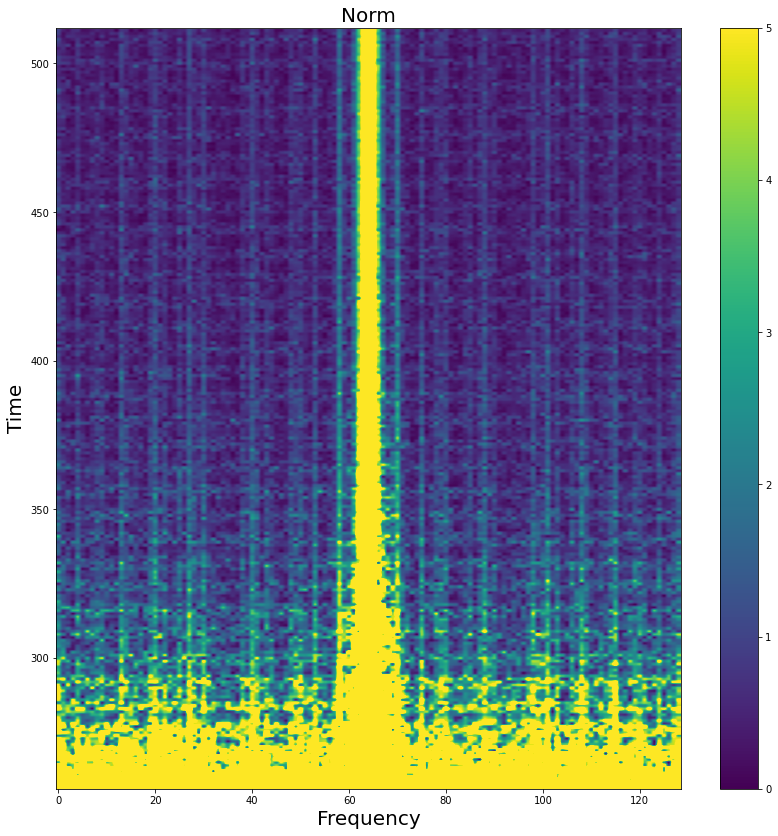

In [42]:
%%time
plt.figure(figsize=(14,14))
plt.imshow(ft_norm.T,aspect='auto',interpolation=None, vmin=0, vmax=5) #transposing concatenated data to ensure that x and y axis are correctly orientated on the plot
plt.xlabel('Frequency', size=20)
plt.ylabel('Time', size=20)
plt.title('Norm',size=20)
plt.ylim(256,512)
plt.colorbar()
# plt.savefig('../Dynamic/Fourier_Transform_Dynamic_Spectra_Test_Norm.png')

In [85]:
# nan_mean = np.nanmean(nan_data)
# for j in range(len(nan_data[0,:])):
#     for i in range(len(nan_data[:,0])):
#         if (nan_data[i,j]==nan):
#             print('o')

In [64]:
ft_data = np.fft.fft2(nan_data)
ft_shift = np.fft.fftshift(ft_data)

In [47]:
#binning conjugate spectrum before plotting s.t. 128-512 pixels are plotted on both axes.

In [44]:
print(weighted_mean_data)

[[0.0551469  0.0533582  0.05053786 ... 0.11128982 0.10960139 0.10974966]
 [0.29931832 0.29849302 0.2967757  ... 0.76640882 0.77883603 0.79365282]
 [0.27940228 0.27644373 0.27219654 ... 0.54099679 0.54869205 0.56152313]
 ...
 [0.27985233 0.28486037 0.29028272 ... 0.50337643 0.49522808 0.49485179]
 [0.25362801 0.25696017 0.25136076 ... 0.47078317 0.46856727 0.46480612]
 [0.31397143 0.31418051 0.31068591 ... 0.48580571 0.47655066 0.47445148]]


In [31]:
ft_data = np.fft.fft2(weighted_mean_data)
ft_shift = np.fft.fftshift(ft_data)

In [41]:
print(ft_data)

[[25.91879027+0.j          0.5694993 +3.35161251j  0.40308599+2.57145681j
  ...  0.66622586-1.64412537j  0.40308599-2.57145681j
   0.5694993 -3.35161251j]
 [-3.39532156+2.36896146j  0.64659304-1.30294847j -3.3182761 +0.75924098j
  ... -1.08932298+1.27982435j  1.67275806+0.28297679j
  -2.78094074+2.89125982j]
 [ 0.21716536-1.81488427j  1.76419536-1.06815238j  1.00549494+0.93495291j
  ...  0.23993377+0.47042584j -1.82552016+0.48891322j
   0.12313624-2.25842924j]
 ...
 [ 0.24770275+0.95507484j  0.40941047-0.77983495j  0.72491049-0.43394916j
  ... -0.26305693-1.10496089j -0.03447984+0.13663948j
   0.13035885-0.93767764j]
 [ 0.21716536+1.81488427j  0.12313624+2.25842924j -1.82552016-0.48891322j
  ...  1.02069755-1.71220067j  1.00549494-0.93495291j
   1.76419536+1.06815238j]
 [-3.39532156-2.36896146j -2.78094074-2.89125982j  1.67275806-0.28297679j
  ...  0.34573554+2.77187083j -3.3182761 -0.75924098j
   0.64659304+1.30294847j]]


In [32]:
weighted_mean_data_2 = weighted_mean_data.T
ft_data_2 = np.fft.fft2(weighted_mean_data_2)
ft_shift_2 = np.fft.fftshift(ft_data_2)

In [50]:
normnorm_data = np.sqrt(ft_shift_2.real**2 + ft_shift_2.imag**2)
print(normnorm_data)

[[0.00047184 0.00077258 0.00073471 ... 0.00073471 0.00077258 0.00047184]
 [0.00071279 0.00100303 0.00077039 ... 0.0009197  0.00066758 0.00106714]
 [0.00124088 0.00024105 0.00040709 ... 0.0008584  0.00031589 0.00078535]
 ...
 [0.00051442 0.00091081 0.00142743 ... 0.00195587 0.0015593  0.00040814]
 [0.00078535 0.00031589 0.0008584  ... 0.00040709 0.00024105 0.00124088]
 [0.00106714 0.00066758 0.0009197  ... 0.00077039 0.00100303 0.00071279]]


CPU times: user 617 ms, sys: 8 ms, total: 625 ms
Wall time: 626 ms


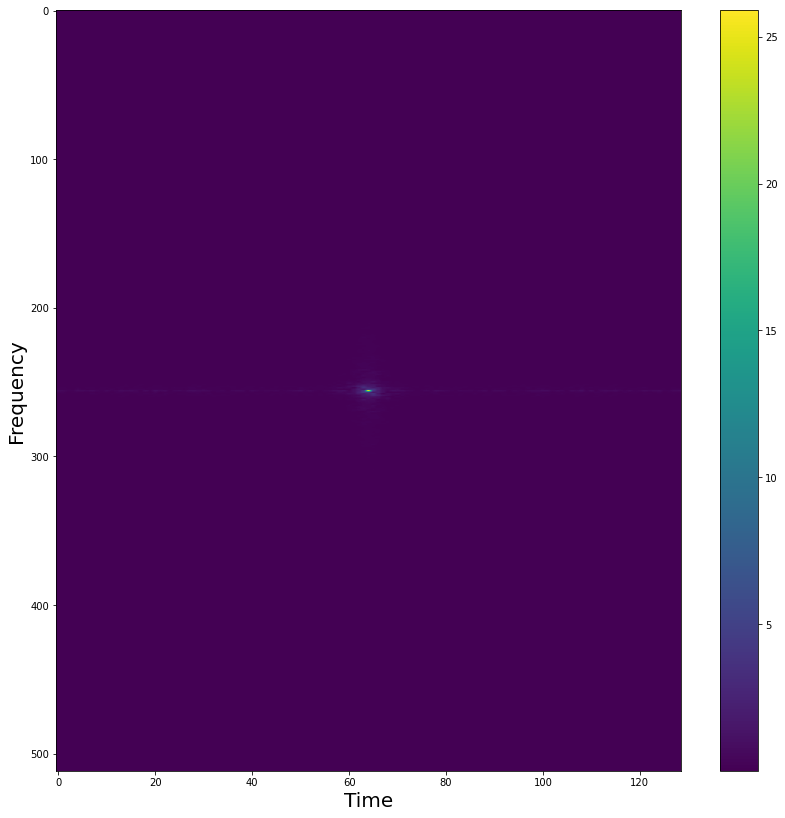

In [51]:
%%time
plt.figure(figsize=(14,14))
plt.imshow(normnorm_data,aspect='auto',interpolation=None) #transposing concatenated data to ensure that x and y axis are correctly orientated on the plot
plt.xlabel('Time', size=20)
plt.ylabel('Frequency', size=20)
plt.colorbar()
plt.savefig('../Dynamic/Fourier_Transform_Dynamic_Spectra_Test_1.png')

In [40]:
FT_Data_y = scipy.fft.fft(master_stack,axis=1)
# FT_Data_x = scipy.fft.fft(master_stack,axis=0)
# FTx = np.zeros_like(master_stack[:,0])
# FTy = np.zeros_like(master_stack[0,:])
# FTx = FT_Data_x[axis=0]
# FTy = FT_Data_x[axis=1]
# FT_Data = ((,FT_Data_y))
print(master_stack.shape)
print(FT_Data_y.shape)

(129, 32768)
(129, 32768)


In [19]:
FT_Data = fft(master_stack)

<ipython-input-19-497d31f9e1be>:1: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  FT_Data = fft(master_stack)


TypeError: Image data of dtype complex128 cannot be converted to float

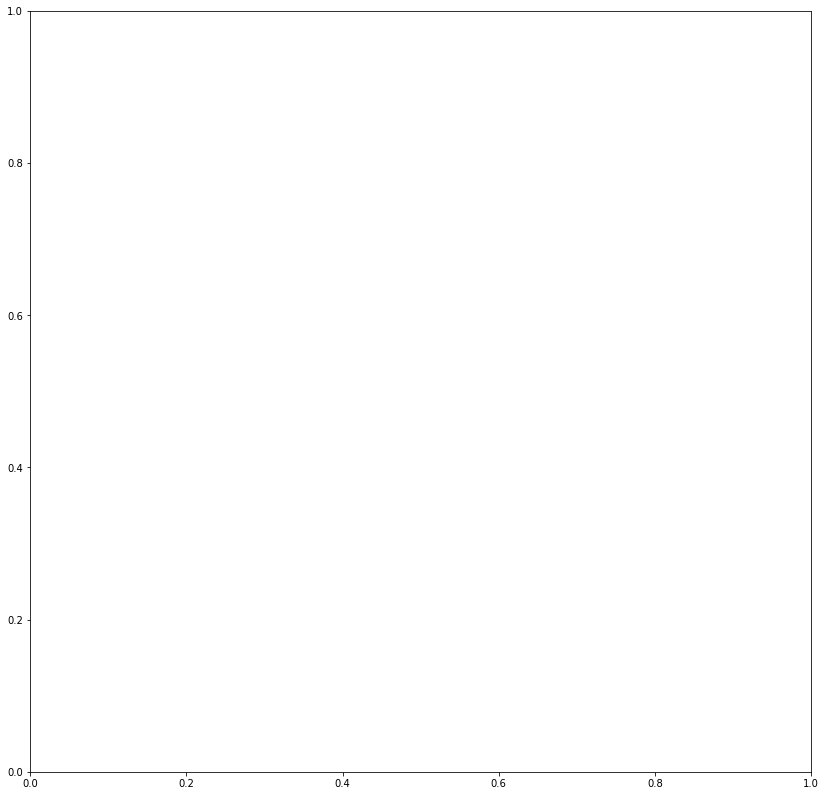

In [38]:
%%time
plt.figure(figsize=(14,14))
plt.imshow(FT_Data_y.T,aspect='auto') #transposing concatenated data to ensure that x and y axis are correctly orientated on the plot
plt.xlabel('Time', size=20)
plt.ylabel('Frequency', size=20)
plt.colorbar()
plt.savefig('../Dynamic/Fourier_Transform_Dynamic_Spectra_test_1.png')